In [1]:
from fastai.text import *
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
path = 'data/Yelp/'
df_meta = pd.read_csv(path+'output_meta_yelpResData_NRYRcleaned.txt', sep=' ', header=None)

df_meta.head(3)

,0,1,2,3,4,5,6,7,8
0,9/22/2012,GtwU21YOQn-wf4vWRUIx6w,bNYesZ944s6IJVowOnB0iA,pbEiXam9YJL3neCYHGwLUA,N,0,0,0,5
1,9/22/2012,0LpVTc3,TRKxLC3y-ZvP45e5iilMtw,pbEiXam9YJL3neCYHGwLUA,N,0,0,0,5
2,9/19/2012,tljtLzf68Fkwf,0EMm8umAqXZzyhxNpL4M9g,pbEiXam9YJL3neCYHGwLUA,N,0,0,2,3


In [3]:
df_reviews = pd.read_csv(path+'output_review_yelpResData_NRYRcleaned.txt', sep='\r', header=None)
df_reviews.head(3)

,0
0,"Unlike Next, which we'd eaten at the previous ..."
1,Probably one of the best meals I've had ever. ...
2,Service was impeccable. Experience and present...


In [4]:
df_meta_reviews = pd.merge(df_meta, df_reviews, left_index=True, right_index=True)
df_meta_reviews = df_meta_reviews.rename(columns={'0_x': 'date', 1: 'id', 2: 'id2', 3: 'id3', 4:'label', '0_y': 'text'})
df_meta_reviews = df_meta_reviews[['label', 'text']]

In [5]:
df_meta_reviews.head(3)

,label,text
0,N,"Unlike Next, which we'd eaten at the previous ..."
1,N,Probably one of the best meals I've had ever. ...
2,N,Service was impeccable. Experience and present...


In [6]:
# Downsample majority class (random undersampling)
df_majority = df_meta_reviews[df_meta_reviews.label == 'N']
df_minority = df_meta_reviews[df_meta_reviews.label == 'Y']


In [7]:
from sklearn.utils import resample
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples= len(df_minority),     # to match minority class
                                 random_state=123) # reproducible results

In [8]:
df_downsampled = pd.concat([df_majority_downsampled, df_minority])

In [9]:
# Create training and validation split of data (it keeps the same % as in the original dataset)
X_train, X_test, y_train, y_test = train_test_split(df_downsampled, df_downsampled['label'], test_size=0.3, random_state=0, stratify=df_downsampled['label'])

# Check split
#X_train[['label', 'text']].groupby(['label']).agg(['count'])

# Generate bool is_valid to flag validiation
X_train['is_valid'] = False
X_test['is_valid'] = True

# Generate final dataset
df = X_train.append(X_test)

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


## Language model

In [10]:
#data_lm = TextLMDataBunch.from_df(path=path, 
#                                  train_df=df,
#                                  valid_df=df,
#                                  label_cols='label',
#                                  text_cols='text')

bs = 48
data_lm = (TextList.from_df(df, path, cols='text')
         .split_by_rand_pct(0.1)
         .label_for_lm()
         .databunch(bs=bs))

In [11]:
data_lm.save('YelpChi_lm.pkl')

In [12]:
data_lm = load_data(path, 'YelpChi_lm.pkl', bs=bs)

In [13]:
data_lm.show_batch()

idx,text
0,", well you can xxunk one and see why rick is the master ! xxup fact : you have nt lived til you ve had bean to cup hot cocoa -it will give you xxunk g spot xxunk . i miss this place greatly in xxup nyc xxbos xxmaj my country friends decided they wanted to try a xxmaj chicago hot dog ... so i figured why not , i"
1,"this place is xxup bossy . xxmaj strolled in at around 9 p.m. and waited for about 20 minutes . xxmaj they initially tried to seat us at the tables where you sit cross xxunk , but being that xxmaj coco is xxunk "" and meaty ... he was n't built to fit under the table with the rest of us . xxmaj he also has never been able to"
2,"the restaurant , we had to be careful what table we sat at because the air conditioner was dripping on almost all the booths in front ... kind of weird . xxmaj however , i paid five whole dollars for some solid food ! xxbos i go to xxmaj fox & xxmaj obel on a regular basis because it 's right across the street from where i work . xxmaj"
3,"unique setup with three levels . xxmaj the service sucks . xxmaj the food is really good , and the variety of mix of odd ingredients is a surprise for a sports bar . xxbos xxmaj this place rules . xxmaj really . i mean , it xxunk and probably one of my best dining experiences i have had in a while . i came here with a group of"
4,to drink . xxmaj as its early in the morning i would love to get that first cup of coffee . i have sat at the bar once and booths the other times and always had to wait like 10 mins to get some service and one time had to ask the hostess to send me a server . i will continue going to this place cause the xxmaj people


In [14]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [15]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


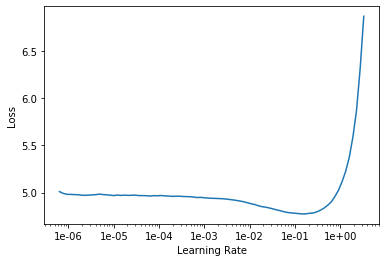

In [16]:
#learn.recorder.plot(skip_end=15)
learn.recorder.plot()

In [17]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.853192,3.731196,0.295968,03:38


In [18]:
learn.save('fit_head')

In [19]:
learn.load('fit_head');

In [20]:
learn.unfreeze()

In [21]:
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.609281,3.622452,0.309528,04:25
1,3.492683,3.539945,0.318321,04:25
2,3.399417,3.484339,0.324607,04:26
3,3.252902,3.459003,0.327972,04:26
4,3.085050,3.471737,0.327754,04:26
5,2.901996,3.503481,0.326945,04:25
6,2.722019,3.547701,0.323786,04:25
7,2.575645,3.594026,0.321286,04:28
8,2.459366,3.629600,0.319508,04:30
9,2.416410,3.645000,0.318921,04:30


In [23]:
learn.save('fine_tuned')

In [24]:
learn.load('fine_tuned');

In [25]:
TEXT = "I do not liked this restaurant because"
N_WORDS = 40
N_SENTENCES = 2
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.76) for _ in range(N_SENTENCES)))

I do not liked this restaurant because so many reviews would say it was bad . i went in on a Saturday around 5:30 and the place was still packed . It was a slow meeting and they lost my seat . Onto the
I do not liked this restaurant because i have staples everyone know about it . i have n't taken everything from the first bite to the last . The service here is top notch . We really enjoy the Chicago style pizza .


In [26]:
learn.save_encoder('fine_tuned_enc')

## Classifier

In [27]:
# Change the order of the columns
df = df[['text', 'label', 'is_valid']]
df.head(3)

,text,label,is_valid
54084,Rick bayless: Enough said - the man is a geniu...,Y,False
22003,My country friends decided they wanted to try ...,N,False
54939,"If you haven't been here yet, then it is too l...",Y,False


In [28]:
data_clas = (TextList.from_df(df, path, cols=['text', 'label', 'is_valid'], vocab=data_lm.vocab)
             #grab all the text files in path
             .split_from_df()
             #split by is_valid column (that only keeps 'train' and 'test' so no need to filter)
             .label_from_df(cols='label')
             #label them all with their folders
             .databunch(bs=bs))


In [29]:
data_clas.save('data_clas.pkl')


In [30]:
data_clas.show_batch()

text,target
"xxbos xxrep 4 * xxup this xxup review xxup is xxup in xxup regards xxup to xxup dinner xxup service xxrep 4 * xxmaj brian and i read on facebook that nana was open for dinner service from 6 - xxup 9pm on xxmaj tues / xxmaj we d / xxmaj thurs of this week , as a trial for the "" pre grand opening "" on xxmaj friday ,",N
"xxbos i xxunk xxmaj alinea this past xxmaj friday night . i am torn about what to write for this review . xxmaj overall i enjoyed the experience , and i thought some of the dishes were absolutely hands down the most innovative food i have ever seen or tasted but i did n't leave there feeling completely blown away . xxmaj now , the only experience i have to",Y
"xxbos xxmaj so a ton has been said about the restaurant , but this one 's for the hotel , which may be my new favorite place to stay ever , so here goes ... xxmaj first off , i was a little nervous about the whole overnight experience at xxup l&e. xxmaj the photos on the website looked super cute but the bathrooms looked slightly challenging for super modest",N
xxbos i 'm a little torn here about how to rate xxmaj nana . xxmaj food alone gets a well deserved 5 stars . xxmaj everything else lacked some . xxmaj so let 's break it down xxrep 5 . xxmaj food : 5 + stars xxmaj service : 2 stars - max . xxmaj ambiance : 4 stars xxmaj that comes out to an average of xxunk stars so,N
"xxbos i had the best margarita of my life in here , and the second best as well . i am xxunk so i had to try two different kinds for variety . xxmaj the xxmaj topolo margarita had xxmaj sauza xxmaj xxunk tequila , xxmaj torres orange liqueur , housemade limonada and was shaken tableside . xxmaj it was my fave of the two varietals , being a true",N


In [31]:
data_clas = load_data(path, 'data_clas.pkl', bs=bs)
#len(data_clas.vocab.itos) == len(data_lm.vocab.itos)

In [32]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc');

In [33]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


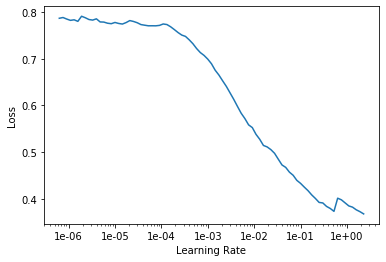

In [34]:
learn.recorder.plot()

In [35]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.085621,0.003704,0.998976,01:46


In [36]:
learn.save('first')

In [37]:
learn.load('first');

In [38]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.020418,0.000274,1.000000,02:19


In [39]:
learn.save('second')

In [40]:
learn.load('second');

In [41]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.004318,0.000022,1.000000,02:54


In [42]:
learn.save('third')

In [43]:
learn.load('third');

In [44]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.009146,0.000025,1.000000,04:35
1,0.001261,0.000014,1.000000,03:37


In [45]:
learn.predict("xxbos i xxunk xxmaj alinea this past xxmaj friday night . i am torn about what to write for this review . xxmaj overall i enjoyed the experience , and i thought some of the dishes were absolutely hands down the most innovative food i have ever seen or tasted but i did n't leave there feeling completely blown away . xxmaj now , the only experience i have to")

(Category Y, tensor(1), tensor([0.0026, 0.9974]))

## Classification interpretation

In [49]:
# Tabulation showing the first k texts in top_losses along with their prediction, actual,loss, 
# and probability of actual class. max_len is the maximum number of tokens displayed. 
# If max_len=None, it will display all tokens.
txt_ci = TextClassificationInterpretation.from_learner(learn)
txt_ci.show_top_losses(5)

Text,Prediction,Actual,Loss,Probability
"xxbos xxmaj best xxmaj veggie xxmaj patty i 've ever had ... xxmaj i've been vegan , xxmaj veggie , and occasionally eat burgers now , and this veggie burger is phenomenal . xxmaj staff is nice , beer is good and it 's a good speed all around . xxmaj get it ! y xxmaj true",N,Y,0.00,0.00
"xxbos xxmaj first of all , it 's a little pretentious and pricey . xxmaj it looks like a dive on the outside , it 's kind of cold , and not a whole lot of smiles . xxup but the drink menu is one of the most creative i have ever experienced . xxmaj the decor is classic and beautiful . xxmaj no cell phones , so turn it",Y,Y,0.00,1.00
xxbos xxmaj just ordered delivery .. i think maybe going there would have been a better idea ! xxmaj the girl who took the order was super friendly .. she said the guy would be over in about 15 .. so he calls me 20 mins later and xxunk what my address is ? ! xxmaj so i m thinking my burger is not going to be remotely warm since,Y,N,0.00,0.00
"xxbos xxmaj amazing , amazing , amazing ! xxmaj there is nothing left i can say about xxmaj pequod 's that has n't already been said by the other xxunk reviewers . xxmaj the caramelized crust , the pan blackened bottom , and the secret sauce are the 3 components that make this the best deep dish in xxmaj chicago . xxmaj seating can be tricky on a busy night",Y,N,0.00,0.00
xxbos xxmaj had a great lunch at xxmaj sunda with a client . xxmaj earned some extra points with them for a great recommendation ! xxmaj we shared a couple of apps and 4 rolls ... delicious ! xxmaj loved the xxmaj firecracker ! ! xxmaj strongly suggest a lunch at xxmaj sunda . y xxmaj true,Y,Y,0.00,1.00


### Sequential Jacobian

In [50]:
import matplotlib.cm as cm
test_text = "xxbos i xxunk xxmaj alinea this past xxmaj friday night . i am torn about what to write for this review . xxmaj overall i enjoyed the experience , and i thought some of the dishes were absolutely hands down the most innovative food i have ever seen or tasted but i did n't leave there feeling completely blown away . xxmaj now , the only experience i have to"
txt_ci.show_intrinsic_attention(test_text,cmap=cm.Purples)

/opt/conda/conda-bld/pytorch_1565272271120/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1565272271120/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1565272271120/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1565272271120/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.


In [51]:
# Raw attention values
txt_ci.intrinsic_attention(test_text)[1]

/opt/conda/conda-bld/pytorch_1565272271120/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1565272271120/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1565272271120/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1565272271120/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.


tensor([0.0492, 0.0859, 0.1084, 0.4470, 0.1868, 1.0000, 0.2095, 0.3213, 0.1194,
        0.1664, 0.0736, 0.0355, 0.0609, 0.2376, 0.4720, 0.1866, 0.2668, 0.1967,
        0.2327, 0.0816, 0.0834, 0.0861, 0.0418, 0.0382, 0.1199, 0.0436, 0.1202,
        0.0348, 0.0849, 0.0236, 0.0328, 0.0470, 0.1300, 0.1228, 0.0515, 0.0413,
        0.1479, 0.0684, 0.2403, 0.3023, 0.1191, 0.0817, 0.1361, 0.3175, 0.1281,
        0.0698, 0.0547, 0.0540, 0.1092, 0.0621, 0.0563, 0.0403, 0.0432, 0.0704,
        0.0781, 0.1781, 0.0815, 0.1526, 0.1766, 0.1232, 0.0391, 0.0252, 0.0353,
        0.1746, 0.0949, 0.1511, 0.4337, 0.7605, 0.3224, 0.4402, 0.4768],
       device='cuda:0')

### Review pertubations (approach similar to Lime)

In [82]:
# Save predictions, index and probabilities (this is required for Lime)
def predict_fn(txt):
    pred_class, idx, prob = learn.predict(test_text)
    #print(pred_class)
    return prob.reshape(-1, 2).numpy()


def softmax(x):
    tmp = np.zeros_like(x)
    """Compute softmax values for each sets of scores in x."""
    for i in range(x.shape[0]):
        s = np.exp(x[i, :])/np.sum(np.exp(x[i, :]))
        tmp[i, :] = s
    return tmp # only difference


def batch_predict(texts):
    for i, text in enumerate(texts):
        output = predict_fn(text)
        #print (output)
        if i == 0:
            preds = output
        else:
            preds = np.concatenate((preds, output), axis=0 )
    return softmax(preds.reshape(-1, len(data_clas.unique())))


In [66]:
def to_np(x): 
    "Convert a tensor to a numpy array."
    return x.data.cpu().numpy()

def prediction_fn(text):
    res = []
    # Ask FastText for the top 10 most likely labels for each piece of text.
    # This ensures we always get a probability score for every possible label in our model.
    pred_class, idx, probabilities = learn.predict(text)

    # For each prediction, sort the probabaility scores into the same order
    # (I.e. no_stars, 1_star, 2_star, etc). This is needed because FastText
    # returns predicitons sorted by most likely instead of in a fixed order.
    #for label, probs in zip(pred_class, probabilities):
    #    order = np.argsort(np.array(label))
    #    res.append(probs[order])

    #return np.array(res)
    return probabilities.numpy()

In [68]:
#!pip install lime;

In [83]:
import lime.lime_text
import numpy as np
import webbrowser

explainer = lime.lime_text.LimeTextExplainer(
    # We need to tell LIME how to split the string into words. We can do this
    # by giving it a function to call to split a string up the same way FastText does it.
    #split_expression=tokenize_string,
    # Our FastText classifer uses bigrams (two-word pairs) to classify text. Setting
    # bow=False tells LIME to not assume that our classifier is based on single words only.
    bow=True,
    # To make the output pretty, tell LIME what to call each possible prediction from our model.
    class_names=["No", "Yes"]
)

exp = explainer.explain_instance(
    # The review to explain
    test_text,
    # The wrapper function that returns FastText predictions in scikit-learn format
    classifier_fn=predict_fn,
    # How many labels to explain. We just want to explain the single most likely label.
    #top_labels=1,
    # How many words in our sentence to include in the explanation. You can try different values.
    #num_features=5,
)

ValueError: Found input variables with inconsistent numbers of samples: [5000, 1]

In [ ]:
# Save the explanation to an HTML file so it's easy to view.
# You can also get it to other formats: as_list(), as_map(), etc.
# See https://lime-ml.readthedocs.io/en/latest/lime.html#lime.explanation.Explanation
output_filename = Path(__file__).parent / "explanation.html"
#exp.save_to_file(output_filename)

# Open the explanation html in our web browser.
webbrowser.open(output_filename.as_uri())

In [ ]:
# fin